In [27]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [320]:
EJ = 90*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 300
flux = 0.48
N = 3
dims = 2

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 8*2*np.pi
g_int1 = 0.15*2*np.pi
dimc1 = 10
trunc1 = 4
cavity1 = Cavity(omega_c1,g_int1,dimc1)

omega_c2 = 3*2*np.pi
g_int2 = 0.15*2*np.pi
dimc2 = 10
trunc2 = dims*dimc2
cavity2 = Cavity(omega_c2,g_int2,dimc2)

In [351]:
flux_values = np.linspace(0.35, 0.4, 100)
Hss = []
charge_ops = []
for flux in flux_values:
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    snailc =  SNAILC(snail_back, cavity2, trunc2)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    Hss.append(Hs)
    charge_ops.append(charge_op)

In [352]:
def find_best_b_and_k(a, B, omega):
    min_diff = float('inf')  # Initialize with a very large number
    best_b = None
    best_k = None

    # Iterate over each element in B
    for b in B:
        # Iterate over each k in the range [-1000, 1000]
        for k in range(-1000, 1001):  # 1001 is used to include 1000 in the range
            diff = abs(a - (b + k * omega))
            # Update min_diff and best_b if a smaller difference is found
            if diff < min_diff:
                min_diff = diff
                best_b = b
                best_k = k

    return best_b, best_k, min_diff

In [353]:
import qutip as qt  
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def floquet_spec(Hs,Hc, omega, A):
#     Hs[0][0] = Hs[0][0]+Hs[1][1]
#     Hs[1][1] = Hs[1][1]+Hs[1][1]
    Hs = Qobj(Hs)
    Hc = Qobj(charge_op)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)],] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(dims*dimc2, i) for i in range(2)]
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [-1] * 3
    max_overlaps = [0] * 3
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energy01 = f_energies[max_overlap_indices[1]]-f_energies[max_overlap_indices[0]]
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    return energy01

In [354]:
omega = 6.2*2*np.pi
A = 0.1*2*np.pi
floquet_results = []
for i in range(len(flux_values)):
    floquet_results.append(floquet_spec(Hss[i],charge_ops[i], omega, A))

In [355]:
floquet_results = np.array(floquet_results)

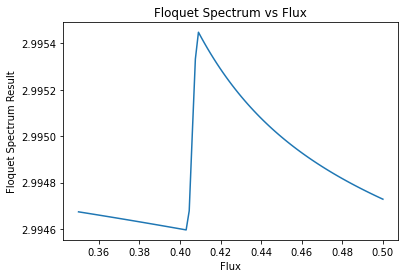

In [356]:
# Plotting
plt.plot(flux_values, floquet_results/2/np.pi, )
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
# plt.ylim(-1.010,-1.006)
plt.show()